c:\Users\varun\anaconda3\envs\MINI2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6945 | Train Accuracy: 23.96% | Test Accuracy: 92.19%
Epoch  10 | Loss: 0.4806 | Train Accuracy: 88.15% | Test Accuracy: 88.11%
Epoch  20 | Loss: 0.4438 | Train Accuracy: 87.71% | Test Accuracy: 88.13%
Epoch  30 | Loss: 0.4097 | Train Accuracy: 89.35% | Test Accuracy: 93.74%
Epoch  40 | Loss: 0.3930 | Train Accuracy: 93.86% | Test Accuracy: 89.50%
Epoch  50 | Loss: 0.3906 | Train Accuracy: 93.88% | Test Accuracy: 89.54%
Epoch  60 | Loss: 0.3742 | Train Accuracy: 93.10% | Test Accuracy: 93.94%
Epoch  70 | Loss: 0.3671 | Train Accuracy: 93.91% | Test Accuracy: 93.91%
Epoch  80 | Loss: 0.3586 | Train Accuracy: 93.88% | Test Accuracy: 93.88%
Epoch  90 | Loss: 0.3524 | Train Accuracy: 93.90% | Test Accuracy: 93.80%
Epoch 100 | Loss: 0.3483 | Train Accuracy: 94.00% | Test Accuracy: 93.99%
Epoch 110 | Loss: 0.3462 | Train Accuracy: 93.99% | Test Accuracy: 93.

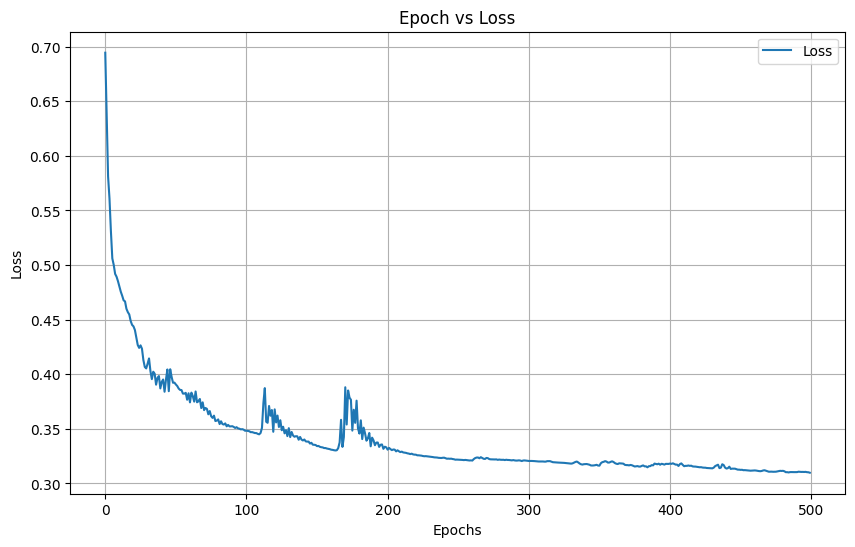

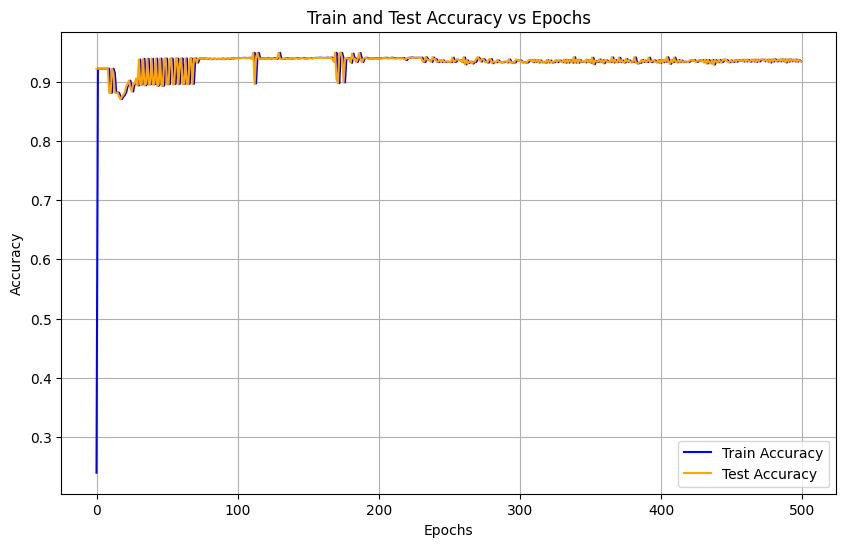

Precision: 0.5781
Recall: 0.5814
F1 Score: 0.5798


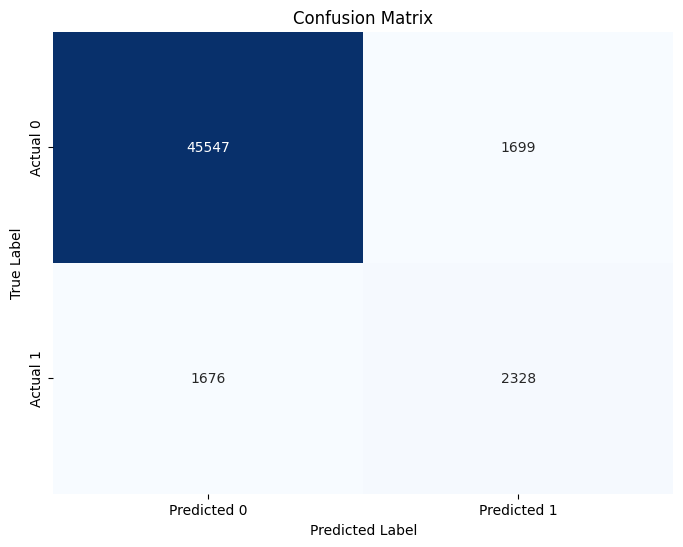

In [1]:
#GAT
import torch
import os
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edges
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []
for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GAT model

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
       
        self.conv1 = GATConv(data.num_node_features, 16, heads=8, concat=True)
  
        self.conv2 = GATConv(16 * 8, 16, heads=8, concat=True)
    
        self.conv3 = GATConv(16 * 8, 16, heads=8, concat=True)
        
        self.conv4 = GATConv(16 * 8, 2, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        return x


model = GAT()

class_counts = torch.bincount(data.y)
# Use log scaling for weights
# class_weights = 1.0 / (class_counts.float() + 1e-6)  # Add small value to avoid division by zero
# class_weights = torch.log1p(class_weights)  # Apply logarithmic normalization

# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Apply square root scaling
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# class_counts = torch.bincount(data.y)
# class_weights = 1.0 / class_counts.float()
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

np.random.shuffle(y_0_indices.numpy())
np.random.shuffle(y_1_indices.numpy())

train_0_size = int(0.8 * len(y_0_indices))
train_1_size = int(0.8 * len(y_1_indices))

train_indices = torch.cat([y_0_indices[:train_0_size], y_1_indices[:train_1_size]])
test_indices = torch.cat([y_0_indices[train_0_size:], y_1_indices[train_1_size:]])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Training loop
train_accuracies = []
test_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_test = model(data.x, data.edge_index)
        pred_test = out_test.argmax(dim=1)
        test_acc = (pred_test[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

# Plotting loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), test_accuracies, label="Test Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation metrics
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[test_mask], y_pred[test_mask])
precision = precision_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
recall = recall_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[test_mask], y_pred[test_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248


c:\Users\varun\anaconda3\envs\MINI2\lib\site-packages\ipykernel_launcher.py:116: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)


Epoch   0 | Loss: 0.7021 | Train Accuracy: 7.81% | Validation Accuracy: 71.03%
Epoch  10 | Loss: 0.5609 | Train Accuracy: 92.19% | Validation Accuracy: 94.01%
Epoch  20 | Loss: 0.5148 | Train Accuracy: 92.19% | Validation Accuracy: 94.01%
Epoch  30 | Loss: 0.4679 | Train Accuracy: 92.35% | Validation Accuracy: 80.30%
Epoch  40 | Loss: 0.4347 | Train Accuracy: 90.06% | Validation Accuracy: 76.64%
Epoch  50 | Loss: 0.4177 | Train Accuracy: 90.09% | Validation Accuracy: 76.31%
Epoch  60 | Loss: 0.4107 | Train Accuracy: 90.57% | Validation Accuracy: 76.53%
Epoch  70 | Loss: 0.4007 | Train Accuracy: 90.55% | Validation Accuracy: 76.52%
Epoch  80 | Loss: 0.3948 | Train Accuracy: 90.55% | Validation Accuracy: 76.50%
Epoch  90 | Loss: 0.3906 | Train Accuracy: 90.55% | Validation Accuracy: 76.49%
Epoch 100 | Loss: 0.3873 | Train Accuracy: 90.55% | Validation Accuracy: 76.49%
Epoch 110 | Loss: 0.3852 | Train Accuracy: 90.55% | Validation Accuracy: 76.49%
Epoch 120 | Loss: 0.3839 | Train Accuracy

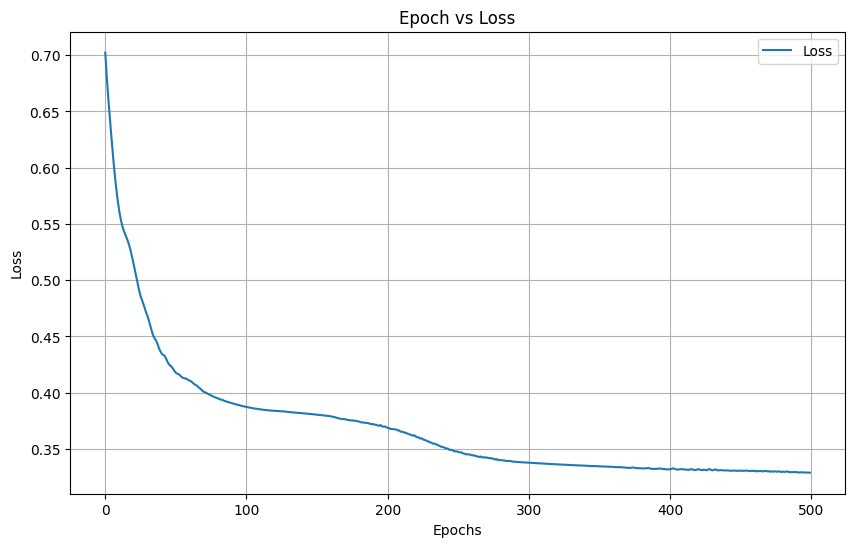

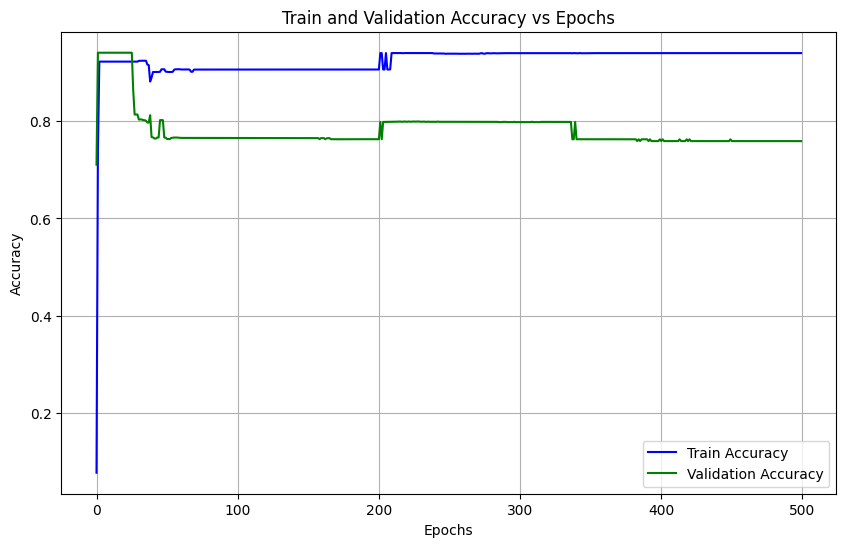

Precision: 0.6369
Recall: 0.5167
F1 Score: 0.5705


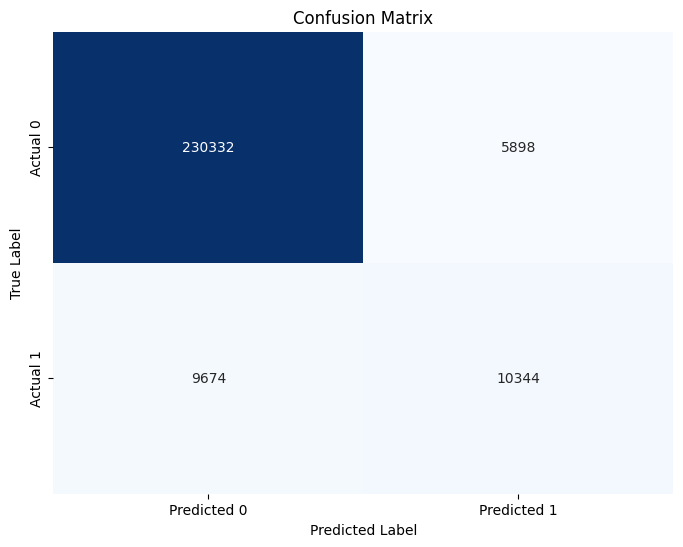

In [2]:
#GAT V 24-11
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)


feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")


labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        # Replace GCNConv with GATConv
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

class_counts = torch.bincount(data.y)
#class_weights = 1.0 / class_counts.float()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]

train_indices = torch.cat([y_0_indices, y_1_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\6-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\6-11\node_contract_status_connected.txt" 
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\6-11\extractedcolumns1.txt" 

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()


validation_accuracies = []
validation_loss_values = []


train_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()

conf_matrix = confusion_matrix(y_true[train_mask], y_pred[train_mask])
precision = precision_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
recall = recall_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)
f1 = f1_score(y_true[train_mask], y_pred[train_mask], average='binary', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Node features shape: (256248, 6)
Labels shape: torch.Size([256248])
Max edge index: 256247, Number of nodes: 256248
Epoch   0 | Loss: 0.6925 | Train Accuracy: 84.24% | Validation Accuracy: 94.01%
Epoch  10 | Loss: 0.5471 | Train Accuracy: 92.19% | Validation Accuracy: 94.01%
Epoch  20 | Loss: 0.4838 | Train Accuracy: 92.19% | Validation Accuracy: 86.44%
Epoch  30 | Loss: 0.4736 | Train Accuracy: 91.46% | Validation Accuracy: 80.31%
Epoch  40 | Loss: 0.4530 | Train Accuracy: 88.63% | Validation Accuracy: 80.13%
Epoch  50 | Loss: 0.4293 | Train Accuracy: 90.36% | Validation Accuracy: 76.63%
Epoch  60 | Loss: 0.4165 | Train Accuracy: 90.54% | Validation Accuracy: 76.25%
Epoch  70 | Loss: 0.4116 | Train Accuracy: 90.54% | Validation Accuracy: 76.25%
Epoch  80 | Loss: 0.4033 | Train Accuracy: 90.55% | Validation Accuracy: 76.49%
Epoch  90 | Loss: 0.3975 | Train Accuracy: 90.55% | Validation Accuracy: 76.49%
Epoch 100 | Loss: 0.3925 | Train Accuracy: 90.55% | Validation Accuracy: 76.49%
Epoc

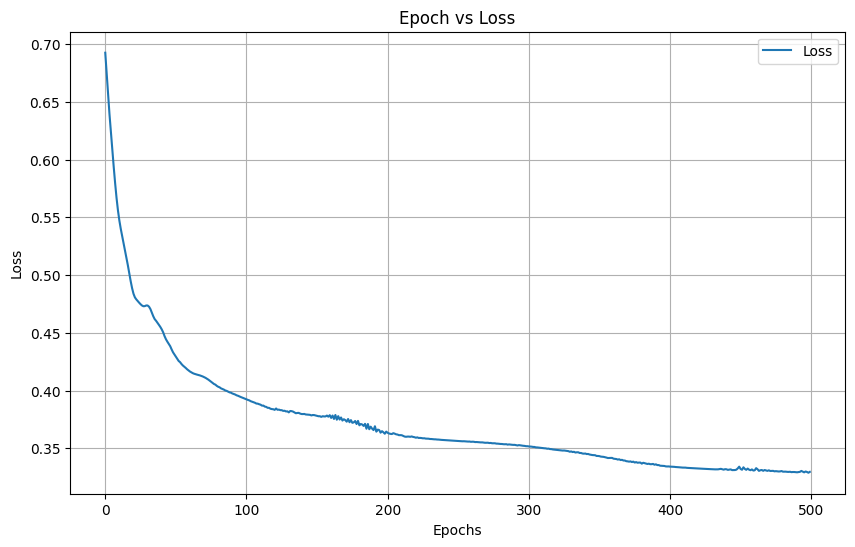

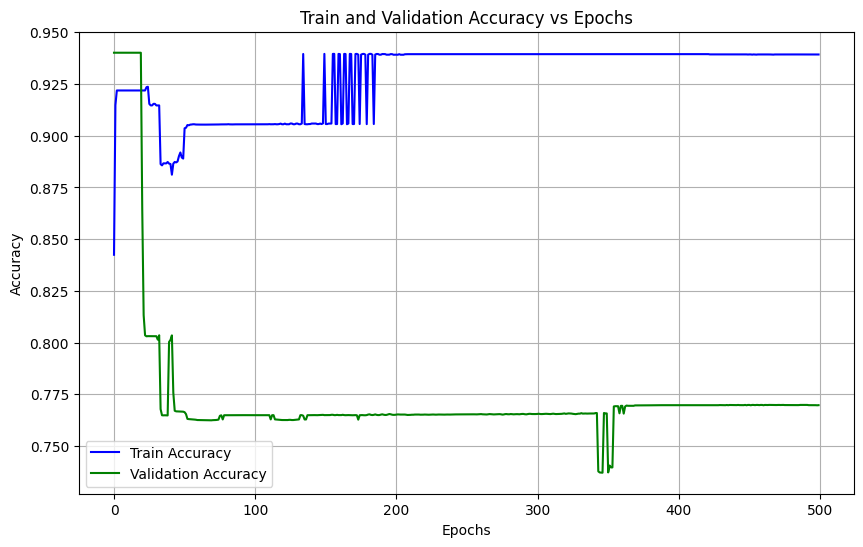

Validation Precision: 0.1563
Validation Recall: 0.6475
Validation F1 Score: 0.2519


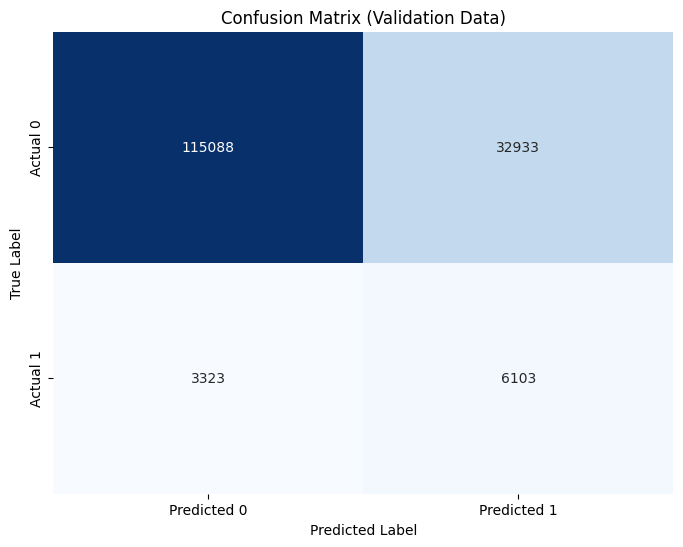

In [3]:
import os
import torch
import torch.nn.functional as F
import seaborn as sns
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load edge data
edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\extractedcolumns1.txt"
edges = np.loadtxt(edge_file, dtype=int)

# Load node features
feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\features"
node_features_list = []

for file_name in os.listdir(feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if node_features_list:
    node_features = np.column_stack(node_features_list)
else:
    raise ValueError("No valid feature files found. Please check your input files.")

# Load labels
labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\2--12\node_contract_status_connected.txt"
labels = torch.tensor(np.loadtxt(labels_file, dtype=int), dtype=torch.long)

print(f"Node features shape: {node_features.shape}")
print(f"Labels shape: {labels.shape}")

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

max_edge_index = edge_index.max()
num_nodes = node_features.shape[0]
print(f"Max edge index: {max_edge_index.item()}, Number of nodes: {num_nodes}")

if max_edge_index >= num_nodes:
    raise IndexError(f"Edge index {max_edge_index.item()} is out of bounds for number of nodes {num_nodes}.")

data = Data(x=torch.tensor(node_features, dtype=torch.float), y=labels, edge_index=edge_index)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_node_features, 16, heads=1)  # Single attention head
        self.conv2 = GATConv(16, 16, heads=1)  # Single attention head
        self.conv3 = GATConv(16, 2, heads=1)  # Single attention head

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        return x

model = GAT()

# Compute class weights for imbalanced data
class_counts = torch.bincount(data.y)
class_weights = 1.0 / torch.sqrt(class_counts.float() + 1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training mask
y_0_indices = (data.y == 0).nonzero(as_tuple=True)[0]
y_1_indices = (data.y == 1).nonzero(as_tuple=True)[0]
train_indices = torch.cat([y_0_indices, y_1_indices])
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# Load validation data
new_feature_folder = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\6-11\features"
new_labels_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\6-11\node_contract_status_connected.txt"
new_edge_file = r"C:\Users\varun\OneDrive\Desktop\MINIIII-2\sk\6-11\extractedcolumns1.txt"

new_node_features_list = []
for file_name in os.listdir(new_feature_folder):
    if file_name.startswith("feature") and file_name.endswith(".txt"):
        file_path = os.path.join(new_feature_folder, file_name)
        try:
            feature_data = np.loadtxt(file_path, dtype=float)
            if feature_data.size == 0:
                print(f"Warning: {file_name} is empty. Skipping this file.")
            else:
                new_node_features_list.append(feature_data)
        except ValueError as e:
            print(f"Warning: Could not read {file_name}. Error: {e}")

if new_node_features_list:
    new_node_features = np.column_stack(new_node_features_list)
    new_labels = torch.tensor(np.loadtxt(new_labels_file, dtype=int), dtype=torch.long)
else:
    raise ValueError("No valid new feature files found. Please check your input files.")

new_edges = np.loadtxt(new_edge_file, dtype=int)
new_edge_index = torch.tensor(list(new_edges), dtype=torch.long).t().contiguous()

# Training and validation
train_accuracies = []
validation_accuracies = []
loss_values = []

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    out = model(data.x, data.edge_index)

    # Compute loss and backpropagate
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Training accuracy
    pred_train = out.argmax(dim=1)
    train_acc = (pred_train[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()

    # Validation accuracy
    model.eval()
    with torch.no_grad():
        out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
        pred_val = out_val.argmax(dim=1)
        val_acc = (pred_val == new_labels).sum().item() / new_labels.size(0)

    # Log metrics
    loss_values.append(loss.item())
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc*100:.2f}% | Validation Accuracy: {val_acc*100:.2f}%')

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(range(500), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(500), train_accuracies, label="Train Accuracy", color='blue')
plt.plot(range(500), validation_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Validation confusion matrix and metrics
model.eval()
with torch.no_grad():
    out_val = model(torch.tensor(new_node_features, dtype=torch.float), new_edge_index)
    y_pred_val = out_val.argmax(dim=1).cpu().numpy()
    y_true_val = new_labels.cpu().numpy()

conf_matrix_val = confusion_matrix(y_true_val, y_pred_val)
precision_val = precision_score(y_true_val, y_pred_val, average='binary', zero_division=0)
recall_val = recall_score(y_true_val, y_pred_val, average='binary', zero_division=0)
f1_val = f1_score(y_true_val, y_pred_val, average='binary', zero_division=0)

print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Data)')
plt.show()
